<a href="https://colab.research.google.com/github/jeongminia/Cancer-Classification/blob/main/weekly/week5/1012_ML_jm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발
- catboost, xgboost, randomforest



# library loading

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.metrics import f1_score

# macro f1 score 함수
def macro_f1_score(y_true, y_pred, n_classes = 26):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [3]:
!git clone https://github.com/jeongminia/Cancer-Classification.git

Cloning into 'Cancer-Classification'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 244 (delta 57), reused 21 (delta 21), pack-reused 164 (from 1)
Receiving objects: 100% (244/244), 12.14 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [4]:
!unzip -qq '/content/Cancer-Classification/data/open.zip'

In [5]:
!unzip -qq '/content/Cancer-Classification/data/preprocessed_data.zip'

# data loading

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [7]:
train.tail(5)

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6200,TRAIN_6200,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [8]:
test.head(5)

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [9]:
len(train), len(test)

(6201, 2546)

# preprocessing

1. 결측값 처리
2. 아미노산 변이 치환
  - WT(정상)
  - missense ← 알파벳숫자**알파벳** (치환)
  - insertion ← **-**숫자알파벳 or 알파벳숫자**ins** (삽입)
  - deletion ← 알파벳숫자**del** (삭제)
  - delins ← 알파벳숫자**delins**알파벳 (집단치환)
  - frameshift ← 알파벳숫자**fs**
  - nonsense ← 알파벳숫자 * (조기종결)

  2.1. category1
  
  2.2. category2

  2.3. category3

3. column WT 차원축소
4. 파생변수 생성 mutation_cnt
5. Custom Numeric Encoding
6. Subclass_encoding

### 결측값 처리

In [10]:
# NaN 개수와 위치 확인
train_nan = train.isna().sum().sum()
train_nan_columns = train.columns[train.isna().any()].tolist()
print(f"train NaN 개수: {train_nan}")
print("NaN 값이 있는 열:")
print(train_nan_columns)

test_nan = test.isna().sum().sum()
test_nan_columns = test.columns[test.isna().any()].tolist()
print(f"test NaN 개수: {test_nan}")
print("NaN 값이 있는 열:")
print(test_nan_columns)

train NaN 개수: 0
NaN 값이 있는 열:
[]
test NaN 개수: 237
NaN 값이 있는 열:
['AK2', 'ATP6V1H', 'CCRL2', 'CFP', 'CNOT2', 'CRAT', 'DPYSL4', 'GUK1', 'IER3', 'INHBB', 'KCNH1', 'MYL1', 'NDUFV1', 'NUDT4', 'POLD2', 'PTCH1', 'PTGES3', 'RBM5', 'SCAMP1', 'SCNN1A', 'SLC25A28', 'SYBU', 'TARS1', 'TMEM97', 'TNFAIP6']


In [11]:
# NaN 값을 'WT'로 치환
train.fillna('WT', inplace=True)
test.fillna('WT', inplace=True)

print()

train_nan = train.isna().sum().sum()
print(f"처리 후 train NaN 개수: {train_nan}")

test_nan = test.isna().sum().sum()
print(f"처리 후 test NaN 개수: {test_nan}")


처리 후 train NaN 개수: 0
처리 후 test NaN 개수: 0


### 아미노산 변이 치환

#### 1. category1

In [12]:
def process_value1(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 문자 그룹 + 숫자 + 문자 그룹
        match = re.match(r'^([A-Za-z*-]*)\d+([A-Za-z*-]*)$', part)

        if match:
            prefix = match.group(1)  # 숫자 앞의 문자 그룹
            suffix = match.group(2)   # 숫자 뒤의 문자 그룹

            # 1. 숫자 앞뒤의 문자 그룹이 같으면 WT로 치환
            if prefix.isupper() and suffix.isupper() and prefix == suffix:
                continue

            # 2. 앞뒤 문자 그룹이 다르면 missense로 분류
            elif prefix.isupper() and suffix.isupper() and prefix != suffix:
                processed_parts.append('missense')

            # 3. 뒤의 문자 그룹에 '*'이 들어가면 nonsense로 치환
            elif '*' in suffix:
                processed_parts.append('nonsense')

            # 4. 뒤의 문자 그룹에 'fs'가 들어가면 frameshift로 치환
            elif 'fs' in suffix:
                processed_parts.append('frameshift')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'delins' in suffix:
                processed_parts.append('delins')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'del' in suffix:
                processed_parts.append('deletion')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'ins' in suffix:
                processed_parts.append('insertion')

            # 6. 뒤에 문자그룹이 없으면 deletion으로 치환
            elif not(suffix):
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [13]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value1)

train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [14]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value1)

test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


#### 2. category2



In [15]:
def process_value2(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^\d+_\d+([A-Za-z*-]+>[A-Za-z*-]+|del)$', part)

        if match:
            variant = match.group(1)  # 변이 정보 그룹


            # 1. >가 있는 경우
            if '>' in variant:
                before, after = variant.split('>')  # '>' 기준으로 나눔
                # 1.1 문자 그룹이 같은 경우 -> WT
                if before.isupper() and after.isupper() and before == after:
                    continue
                # 1.2 문자 그룹이 다른 경우 -> missense
                elif before.isupper() and after.isupper() and before != after:
                    processed_parts.append('missense')
                # 1.3 *가 있는 경우 -> nonsense
                elif '*' in after:
                    processed_parts.append('nonsense')
                # 1.4 fs가 있는 경우 -> frameshift
                elif 'fs' in after:
                    processed_parts.append('frameshift')
                else:
                    print(part)

            # 2. >가 없는 경우
            elif 'del' in variant:
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)


    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [16]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value2)

train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [17]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value2)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


#### 3. category3

In [18]:
def process_value3(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^([A-Za-z]+)\d+_([A-Za-z]+)?\d+([A-Za-z]+)$', part)

        if match:
            variant = match.group(3)  # 변이 정보 그룹

            # 1. >가 있는 경우
            if 'del' in variant and 'ins' in variant:
                processed_parts.append('delins')

            elif 'del' in variant and not('ins' in variant):
                processed_parts.append('deletion')

            elif 'ins' in variant and not('del' in variant):
                processed_parts.append('insertion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [19]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value3)

# 최종 데이터 확인
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [20]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value3)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


### column WT 차원축소
- WT로만 구성된 컬럼 삭제

In [ ]:
train_wt_columns = train.columns[(train == 'WT').all()].tolist()
test_wt_columns = test.columns[(test == 'WT').all()].tolist()

print('데이터셋에서 값이 모두 WT인 열 개수')
print('trainSet: ', len(train_wt_columns))
print('testSet: ', len(test_wt_columns))

데이터셋에서 값이 모두 WT인 열 개수
trainSet:  159
testSet:  29


In [ ]:
cnt = 0
both_wt_columns = []
for gene in train_wt_columns:
  if gene in test_wt_columns:
    both_wt_columns.append(gene)
    cnt += 1

print('두 데이터셋에서 값이 모두 WT인 열 개수:', cnt)
both_wt_columns

두 데이터셋에서 값이 모두 WT인 열 개수: 21


['BOLA2',
 'CROCCP2',
 'EEIG1',
 'G6PC1',
 'GPX4',
 'H2AC25',
 'HBBP1',
 'HYCC2',
 'MIX23',
 'MYL11',
 'NHERF1',
 'NHERF4',
 'PALS1',
 'PHB1',
 'PTTG3P',
 'PVT1',
 'RIGI',
 'SELENOP',
 'SELENOW',
 'SKIC3',
 'XIST']

In [ ]:
train_df = train.drop(columns=both_wt_columns)
test_df = test.drop(columns=both_wt_columns)

### mutation_cnt 파생변수 생성

In [21]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        # 값을 문자열로 변환하여 처리
        val = str(val)
        if val != 'WT':
            # 공백으로 나누어진 패턴 개수를 모두 더하기
            mutation_count += len(val.split())
    return mutation_count

In [22]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['mutation_cnt'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,18
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,12
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,85
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,33
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,8
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,missense,WT,13
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5


In [23]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['mutation_cnt'] = test.iloc[:, 1:].apply(count_mutations, axis=1)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,81
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,frameshift,WT,WT,WT,WT,523
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,6
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,90
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,11
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,missense,WT,WT,WT,WT,missense missense,missense,WT,WT,2231
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4


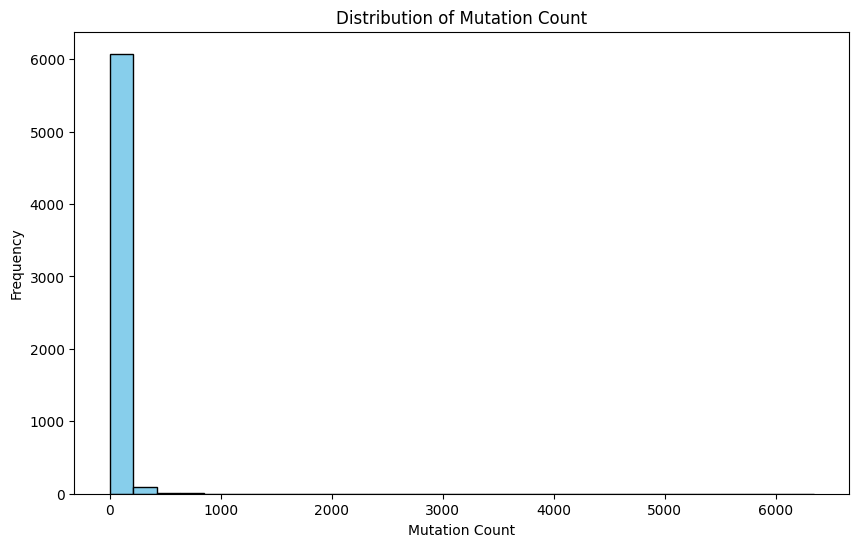

In [24]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
train['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

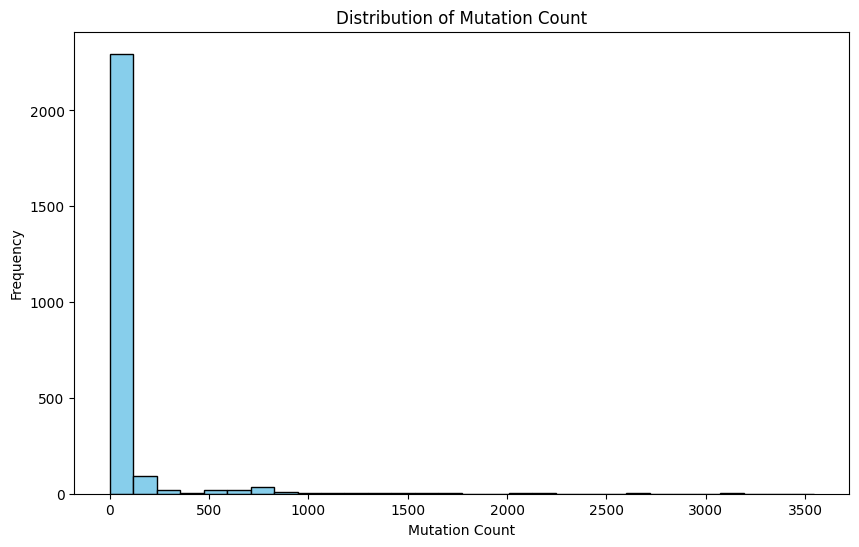

In [25]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
test['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

In [26]:
# SUBCLASS별 mutation_count의 평균 계산
train_mutation_count = pd.DataFrame(train.groupby('SUBCLASS')['mutation_cnt'].mean())
train_mutation_count.sort_values(by='mutation_cnt', ascending=True)

,mutation_cnt
SUBCLASS,
LAML,2.563291
PCPG,3.428571
THCA,3.435185
THYM,3.693878
PRAD,6.030075
LGG,7.109170
GBMLGG,9.904555
SARC,10.358586
KIRC,10.491018


### Custom Numeric Encoding (opt)

Nonsense > Frameshift > Delins > Deletion > Insertion > Missense > WT

In [ ]:
# 변이 유형에 대한 지수 값 정의
mutation_dict = {
    'WT': 10**0,
    'missense': 10**1,
    'insertion': 10**2,
    'deletion': 10**3,
    'delins': 10**4,
    'frameshift': 10**5,
    'nonsense': 10**6
}

# 변이 값을 합산하는 함수 정의
def mutation_to_numeric(value):
    # 문자열인지 확인
    if isinstance(value, str):
        # 공백만 있는 경우 처리
        if value.strip() == '':
            print("value.strip() doesn't work: ", value)
            return 0

        # 공백을 기준으로 변이 분리
        mutations = value.split()  # 공백을 기준으로 분리
        total_value = 0  # 합산 값 초기화

        # 각 변이 유형에 대해 반복
        for m in mutations:
            m = m.strip()  # 공백 제거
            if m in mutation_dict:
                total_value += mutation_dict[m]  # 사전에서 값을 찾아서 더함
         #   else:
         #       print(f"Unknown mutation type: {m}")  # 알 수 없는 변이 유형에 대해 출력

       # if total_value > 1:
       #     print(f"Total value for {value}: {total_value}\n")  # 디버깅 메시지

        return total_value
    else:
        print(value)
        return value  # 숫자나 다른 형식일 경우 그대로 반환


In [ ]:
# 함수 적용
for col in train.columns[2:]:  # ID 제외
    train[col] = train[col].apply(mutation_to_numeric)

In [ ]:
# 함수 적용
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(mutation_to_numeric)

### Subclass_encoding (opt)

SUBCLASS
BRCA      786
KIPAN     515
GBMLGG    461
STES      379
KIRC      334
THCA      324
SKCM      276
PRAD      266
OV        253
LGG       229
HNSC      223
COAD      223
UCEC      198
SARC      198
LUAD      184
LUSC      178
LIHC      158
LAML      158
CESC      155
PCPG      147
TGCT      124
PAAD      120
BLCA      104
THYM       98
ACC        72
DLBC       38
Name: count, dtype: int64


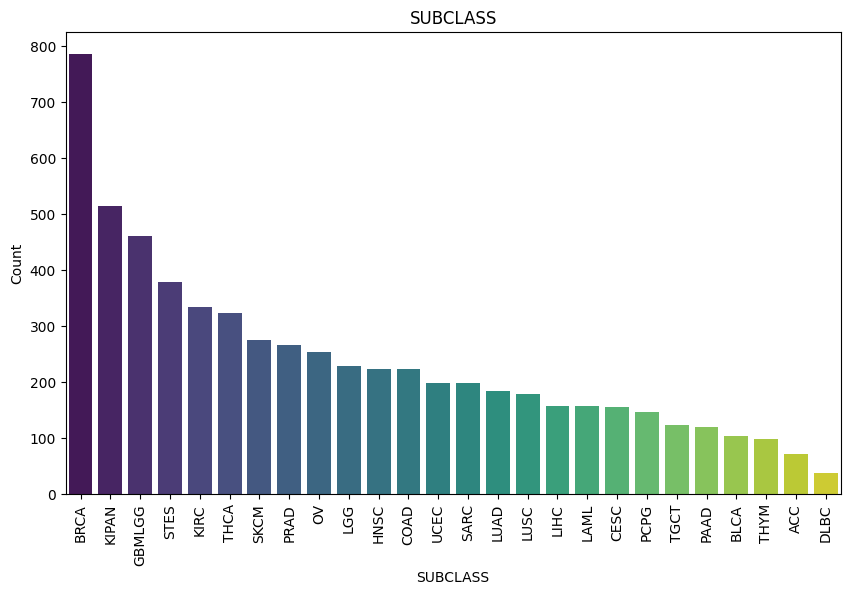

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# SUBCLASS 컬럼의 값 분포를 세는 코드
subclass_counts = train['SUBCLASS'].value_counts()

# 분포 출력
print(subclass_counts)

# 분포를 시각화하는 코드 (막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_counts.index, y=subclass_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('SUBCLASS')
plt.xlabel('SUBCLASS')
plt.ylabel('Count')
plt.show()

#### LabelEncoder

In [28]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


# Model - CatBoost

In [29]:
#train_df = pd.read_csv('preprocessed_train.csv', index_col=None)
#train_df = train_df.drop(columns=['Unnamed: 0'])
#test_df = pd.read_csv('preprocessed_test.csv', index_col=None)
#submission = pd.read_csv('/content/sample_submission.csv')

train_df = train.copy()
test_df = test.copy()

In [31]:
train_df.head()

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TRAIN_0000,8,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,18
1,TRAIN_0001,19,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,12
2,TRAIN_0002,20,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,85
3,TRAIN_0003,9,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4
4,TRAIN_0004,6,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,23


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
X_encoded = X.copy()

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

In [38]:
from imblearn.under_sampling import TomekLinks

# Tomek Links 적용
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)

In [39]:
X_train

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,224
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4687,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
4688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


## 모델 학습

In [40]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.7 MB/s eta 0:00:00


In [41]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

# Pool 객체 생성 (카테고리형 변수 지정)
model = CatBoostClassifier(iterations=200,
                           depth=6,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           verbose=10)

# 4. 모델 학습
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),  # 검증 데이터를 설정
          use_best_model=True,  # 검증 성능이 최고일 때의 모델 사용
          early_stopping_rounds=10)  # 검증 성능이 향상되지 않으면 학습 조기 종료

0:	learn: 3.0752714	test: 3.0826213	best: 3.0826213 (0)	total: 4.41s	remaining: 14m 38s
10:	learn: 2.5268524	test: 2.5994151	best: 2.5994151 (10)	total: 45.2s	remaining: 12m 57s
20:	learn: 2.3676064	test: 2.4565287	best: 2.4565287 (20)	total: 1m 10s	remaining: 10m 1s
30:	learn: 2.2671665	test: 2.3610721	best: 2.3610721 (30)	total: 1m 35s	remaining: 8m 38s
40:	learn: 2.1960436	test: 2.2950881	best: 2.2950881 (40)	total: 2m	remaining: 7m 48s
50:	learn: 2.1602379	test: 2.2629226	best: 2.2629226 (50)	total: 2m 26s	remaining: 7m 9s
60:	learn: 2.1287479	test: 2.2372547	best: 2.2372547 (60)	total: 2m 54s	remaining: 6m 36s
70:	learn: 2.0997122	test: 2.2126556	best: 2.2126556 (70)	total: 3m 20s	remaining: 6m 4s
80:	learn: 2.0722187	test: 2.1891392	best: 2.1891392 (80)	total: 3m 47s	remaining: 5m 34s
90:	learn: 2.0320234	test: 2.1550197	best: 2.1550197 (90)	total: 4m 13s	remaining: 5m 3s
100:	learn: 1.9822715	test: 2.1105322	best: 2.1105322 (100)	total: 4m 49s	remaining: 4m 44s
110:	learn: 1.936

In [42]:
# 테스트 데이터로 예측
y_pred = model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"CatBoost Macro F1 Score: {macro_f1:.2f}")

CatBoost Macro F1 Score: 0.33


In [43]:
feature_importances = model.get_feature_importance()

# Feature Importance를 데이터프레임으로 변환
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Feature Importance 출력
importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
4384,mutation_cnt,44.076763
4107,TP53,13.282165
1888,IDH1,8.250408
474,BRAF,6.898131
2977,PIK3CA,4.468879
...,...,...
1585,GINS4,0.000000
1589,GLA,0.000000
1590,GLCE,0.000000
1591,GLDC,0.000000


In [44]:
print(len(importance_df), len(importance_df[importance_df.Importance > 0.0]['Feature']))

4385 621


## 주요 피쳐로 재학습

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

X_encoded = X.copy()
X_encoded = X_encoded[list(importance_df[importance_df.Importance > 0.0]['Feature'])]

categorical_columns = X_encoded.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
print(categorical_columns)

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

X_train, y_train = tl.fit_resample(X_train, y_train) # 클래스 불균형 해소

Index(['ABCB11', 'ABCC1', 'ABCC2', 'ABCC3', 'ABI3BP', 'ACACA', 'ACADSB',
       'ACRV1', 'ACSL5', 'ADAD1',
       ...
       'WNT1', 'WWC1', 'WWP1', 'XCL1', 'XDH', 'XRCC5', 'XYLT2', 'YWHAZ',
       'ZFP36L1', 'ZFPM2'],
      dtype='object', length=620)


In [53]:
model = CatBoostClassifier(iterations=200,
                           depth=6,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           verbose=10)

# 4. 모델 학습
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),  # 검증 데이터를 설정
          use_best_model=True,  # 검증 성능이 최고일 때의 모델 사용
          early_stopping_rounds=10)  # 검증 성능이 향상되지 않으면 학습 조기 종료

0:	learn: 3.0395082	test: 3.0547070	best: 3.0547070 (0)	total: 634ms	remaining: 2m 6s
10:	learn: 2.4701394	test: 2.5569477	best: 2.5569477 (10)	total: 8.91s	remaining: 2m 33s
20:	learn: 2.2814393	test: 2.3798816	best: 2.3798816 (20)	total: 13.3s	remaining: 1m 53s
30:	learn: 2.2176936	test: 2.3262640	best: 2.3262640 (30)	total: 18.7s	remaining: 1m 41s
40:	learn: 2.1597956	test: 2.2776416	best: 2.2776416 (40)	total: 25.6s	remaining: 1m 39s
50:	learn: 2.1057232	test: 2.2300856	best: 2.2300856 (50)	total: 30.1s	remaining: 1m 27s
60:	learn: 2.0777675	test: 2.2064013	best: 2.2064013 (60)	total: 34.8s	remaining: 1m 19s
70:	learn: 2.0404066	test: 2.1745907	best: 2.1745907 (70)	total: 40.7s	remaining: 1m 13s
80:	learn: 2.0059685	test: 2.1471031	best: 2.1471031 (80)	total: 45.1s	remaining: 1m 6s
90:	learn: 1.9569641	test: 2.1046136	best: 2.1046136 (90)	total: 50.7s	remaining: 1m
100:	learn: 1.9127006	test: 2.0667690	best: 2.0667690 (100)	total: 55.7s	remaining: 54.6s
110:	learn: 1.8816878	test: 

In [54]:
# 테스트 데이터로 예측
y_pred = model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"CatBoost Macro F1 Score: {macro_f1:.2f}")

CatBoost Macro F1 Score: 0.35


In [55]:
X_test = test_df.drop(columns=['ID'])
X_test = X_test[list(importance_df[importance_df.Importance > 0.0].Feature)]
X_test[categorical_columns] = X_test[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))

predictions = model.predict(X_test)
#original_labels = le_subclass.inverse_transform(predictions)

In [56]:
predictions = model.predict(X_test)
original_labels = le_subclass.inverse_transform(predictions)

submission["SUBCLASS"] = original_labels
submission.to_csv('./CatBoost_submission.csv', encoding='UTF-8-sig', index=False)

# Model - XGBoost

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
X_encoded = X.copy()

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

In [83]:
from imblearn.under_sampling import TomekLinks

# Tomek Links 적용
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)

### 모델 학습

In [84]:
import xgboost as xgb

# XGBoost 모델 정의
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
  #  scale_pos_weight=class_weight_dict
)

# evals에 평가할 데이터셋 추가
evals = [(X_train, y_train), (X_valid, y_valid)]

# 모델 학습
xgb_model.fit(X_train, y_train,
              eval_set=evals,
              verbose=True)

[0]	validation_0-mlogloss:2.97190	validation_1-mlogloss:3.01276
[1]	validation_0-mlogloss:2.79991	validation_1-mlogloss:2.86346
[2]	validation_0-mlogloss:2.66762	validation_1-mlogloss:2.75312
[3]	validation_0-mlogloss:2.55831	validation_1-mlogloss:2.66467
[4]	validation_0-mlogloss:2.46621	validation_1-mlogloss:2.59062
[5]	validation_0-mlogloss:2.38635	validation_1-mlogloss:2.52728
[6]	validation_0-mlogloss:2.31528	validation_1-mlogloss:2.47113
[7]	validation_0-mlogloss:2.25070	validation_1-mlogloss:2.42080
[8]	validation_0-mlogloss:2.19292	validation_1-mlogloss:2.37881
[9]	validation_0-mlogloss:2.14129	validation_1-mlogloss:2.34111
[10]	validation_0-mlogloss:2.09353	validation_1-mlogloss:2.30686
[11]	validation_0-mlogloss:2.04996	validation_1-mlogloss:2.27723
[12]	validation_0-mlogloss:2.00934	validation_1-mlogloss:2.24930
[13]	validation_0-mlogloss:1.97184	validation_1-mlogloss:2.22509
[14]	validation_0-mlogloss:1.93757	validation_1-mlogloss:2.20128
[15]	validation_0-mlogloss:1.90461	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [85]:
# 테스트 데이터로 예측
y_pred = xgb_model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"XGBoost Macro F1 Score: {macro_f1:.2f}")

XGBoost Macro F1 Score: 0.37


In [87]:
X_test = test_df.drop(columns=['ID'])
X_test[categorical_columns] = X_test[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))

predictions = xgb_model.predict(X_test)
original_labels = le_subclass.inverse_transform(predictions)

submission["SUBCLASS"] = original_labels
submission.to_csv('./XGB_submission_base.csv', encoding='UTF-8-sig', index=False)

In [86]:
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(len(feature_importance), len(feature_importance[feature_importance.Importance > 0.0]))

4385 1754


### 주요 피처로 재학습

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

X_encoded = X.copy()
X_encoded = X_encoded[list(feature_importance[feature_importance.Importance > 0.0]['Feature'])]

categorical_columns = X_encoded.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
print(categorical_columns)

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

X_train, y_train = tl.fit_resample(X_train, y_train) # 클래스 불균형 해소

Index(['APC', 'XYLT2', 'VHL', 'BRAF', 'IDH1', 'GATA3', 'DCBLD2', 'CACNG1',
       'NPM1', 'PLPPR4',
       ...
       'COL4A2', 'IFIH1', 'SNCB', 'JAK1', 'TLR1', 'PROZ', 'RTN4RL1', 'EOMES',
       'RBPJ', 'MSH5'],
      dtype='object', length=1753)


In [64]:
import xgboost as xgb

# XGBoost 모델 정의
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
  #  scale_pos_weight=class_weight_dict
)

# evals에 평가할 데이터셋 추가
evals = [(X_train, y_train), (X_valid, y_valid)]

# 모델 학습
xgb_model.fit(X_train, y_train,
              eval_set=evals,
              verbose=True)

[0]	validation_0-mlogloss:2.96958	validation_1-mlogloss:3.01172
[1]	validation_0-mlogloss:2.79682	validation_1-mlogloss:2.86364
[2]	validation_0-mlogloss:2.66311	validation_1-mlogloss:2.75395
[3]	validation_0-mlogloss:2.55329	validation_1-mlogloss:2.66463
[4]	validation_0-mlogloss:2.46069	validation_1-mlogloss:2.59082
[5]	validation_0-mlogloss:2.37944	validation_1-mlogloss:2.52654
[6]	validation_0-mlogloss:2.30827	validation_1-mlogloss:2.46856
[7]	validation_0-mlogloss:2.24505	validation_1-mlogloss:2.42083
[8]	validation_0-mlogloss:2.18767	validation_1-mlogloss:2.37787
[9]	validation_0-mlogloss:2.13578	validation_1-mlogloss:2.33705
[10]	validation_0-mlogloss:2.08896	validation_1-mlogloss:2.30366
[11]	validation_0-mlogloss:2.04570	validation_1-mlogloss:2.27283
[12]	validation_0-mlogloss:2.00530	validation_1-mlogloss:2.24404
[13]	validation_0-mlogloss:1.96791	validation_1-mlogloss:2.22125
[14]	validation_0-mlogloss:1.93260	validation_1-mlogloss:2.19696
[15]	validation_0-mlogloss:1.90039	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [65]:
# 테스트 데이터로 예측
y_pred = xgb_model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"XGBoost Macro F1 Score: {macro_f1:.2f}")

XGBoost Macro F1 Score: 0.36


In [68]:
X_test = test_df.drop(columns=['ID'])
X_test = X_test[list(feature_importance[feature_importance.Importance > 0.0].Feature)]
X_test[categorical_columns] = X_test[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))

predictions = xgb_model.predict(X_test)
#original_labels = le_subclass.inverse_transform(predictions)

In [69]:
predictions = xgb_model.predict(X_test)
original_labels = le_subclass.inverse_transform(predictions)

submission["SUBCLASS"] = original_labels
submission.to_csv('./XGB_submission.csv', encoding='UTF-8-sig', index=False)

# Model - RandomForest

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
X_encoded = X.copy()

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

In [71]:
from imblearn.under_sampling import TomekLinks

# Tomek Links 적용
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200,
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# 테스트 데이터로 예측
y_pred = xgb_model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"XGBoost Macro F1 Score: {macro_f1:.2f}")

In [76]:
importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(len(feature_importance), len(feature_importance[feature_importance.Importance > 0.0]['Feature']))

4385 4193


### 주요 피처로 재학습

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train_df['SUBCLASS']

X_encoded = X.copy()
X_encoded = X_encoded[list(feature_importance[feature_importance.Importance > 0.0]['Feature'])]

categorical_columns = X_encoded.select_dtypes(include=['object', 'category']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
print(categorical_columns)

# apply()를 통해 각 열에 LabelEncoder를 적용
X_encoded[categorical_columns] = X_encoded[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

X_train, y_train = tl.fit_resample(X_train, y_train) # 클래스 불균형 해소

Index(['BRAF', 'IDH1', 'VHL', 'TP53', 'APC', 'PIK3CA', 'ATRX', 'PTEN', 'NPM1',
       'GATA3',
       ...
       'LYSMD2', 'CXCL3', 'BCL2L10', 'NUDT11', 'S100A4', 'G0S2', 'SPCS1',
       'AHSP', 'NDUFB1', 'FKBP1B'],
      dtype='object', length=4192)


In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200,
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [79]:
# 테스트 데이터로 예측
y_pred = rf_model.predict(X_valid)

# Macro F1 score 계산
macro_f1 = f1_score(y_valid, y_pred, average='macro')
print(f"XGBoost Macro F1 Score: {macro_f1:.2f}")

XGBoost Macro F1 Score: 0.32


In [80]:
X_test = test_df.drop(columns=['ID'])
X_test = X_test[list(feature_importance[feature_importance.Importance > 0.0].Feature)]
X_test[categorical_columns] = X_test[categorical_columns].apply(lambda col: label_encoders[col.name].fit_transform(col.astype(str)))

predictions = rf_model.predict(X_test)
#original_labels = le_subclass.inverse_transform(predictions)

In [81]:
predictions = rf_model.predict(X_test)
original_labels = le_subclass.inverse_transform(predictions)

submission["SUBCLASS"] = original_labels
submission.to_csv('./rf_submission.csv', encoding='UTF-8-sig', index=False)